<a href="https://colab.research.google.com/github/lurndatascience/MLHax/blob/main/datawig_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Data Missing at random

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import datawig

In [ ]:
#Load Data
flights = sns.load_dataset("flights")
flights['month'] = flights['month'].astype(str) 
flights['year'] = flights['year'].astype(str)

In [ ]:
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:
#Separate Data
flights_train, flights_test = datawig.utils.random_split(flights)

In [ ]:
flights_train

,year,month,passengers
99,1957,Apr,348
60,1954,Jan,204
119,1958,Dec,337
103,1957,Aug,467
83,1955,Dec,278
...,...,...,...
30,1951,Jul,199
86,1956,Mar,317
92,1956,Sep,355
132,1960,Jan,417


In [ ]:
#Fit DataWig imputer and predict
imputer = datawig.SimpleImputer(
    input_columns=['year', 'month'],
    output_column='passengers'
    )

imputer.fit(train_df = flights_train)

imputed = imputer.predict(flights_test)

2022-05-31 07:29:11,527 [INFO]  
========== start: fit model
2022-05-31 07:29:11,533 [WARNING]  Already bound, ignoring bind()
2022-05-31 07:29:11,919 [INFO]  Epoch[0] Batch [0-4]	Speed: 260.45 samples/sec	cross-entropy=15.780900	passengers-accuracy=0.000000
2022-05-31 07:29:11,975 [INFO]  Epoch[0] Train-cross-entropy=14.637551
2022-05-31 07:29:11,982 [INFO]  Epoch[0] Train-passengers-accuracy=0.000000
2022-05-31 07:29:11,986 [INFO]  Epoch[0] Time cost=0.429
2022-05-31 07:29:11,999 [INFO]  Saved checkpoint to "passengers/model-0000.params"
2022-05-31 07:29:12,053 [INFO]  Epoch[0] Validation-cross-entropy=8.800450
2022-05-31 07:29:12,060 [INFO]  Epoch[0] Validation-passengers-accuracy=0.000000
2022-05-31 07:29:12,261 [INFO]  Epoch[1] Batch [0-4]	Speed: 399.78 samples/sec	cross-entropy=14.693674	passengers-accuracy=0.000000
2022-05-31 07:29:12,327 [INFO]  Epoch[1] Train-cross-entropy=13.673453
2022-05-31 07:29:12,330 [INFO]  Epoch[1] Train-passengers-accuracy=0.000000
2022-05-31 07:29:12

In [ ]:
imputed

,year,month,passengers,passengers_imputed
13,1950,Feb,126,92.478139
69,1954,Oct,229,225.772006
77,1955,Jun,315,308.775355
129,1959,Oct,407,411.665643
51,1953,Apr,235,212.540822
49,1953,Feb,196,176.636316
78,1955,Jul,364,361.982084
130,1959,Nov,362,375.196163
72,1955,Jan,242,246.595648
33,1951,Oct,162,159.269557


In [ ]:
from sklearn.metrics import mean_squared_error as mse

#DataWig imputation evaluation
dw_rmse = (mse(imputed['passengers'], imputed['passengers_imputed']))**0.5

In [ ]:
dw_rmse

26.412334839437253

In [ ]:
# Imputation by mean method
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(np.expand_dims(flights_train['passengers'], axis = 1))
y = np.empty(len(flights_test))
y[:] = np.nan
imputed_flights_test = imp_mean.transform(np.expand_dims(y, axis = 1))

In [ ]:
#Mean method evaluation
mean_rmse = (mse(flights_test['passengers'], imputed_flights_test)) ** 0.5

In [ ]:
mean_rmse

126.72533298004623

In [ ]:
#KNN imputation data prep
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first')
flights_train_ohe = pd.DataFrame(ohe.fit_transform(flights_train[['month']]).toarray())
flights_train = flights_train.reset_index(drop= True)
flights_train = flights_train.join(flights_train_ohe)
train_y = np.array(flights_train['passengers'])
flights_train = flights_train.drop(columns = ['month', 'passengers'])
flights_train['passengers'] = train_y

flights_test_ohe = pd.DataFrame(ohe.transform(flights_test[['month']]).toarray())
flights_test = flights_test.reset_index(drop= True)
flights_test = flights_test.join(flights_test_ohe)
test_y = np.array(flights_test['passengers'])
nans = np.empty(len(flights_test))
nans[:] = np.nan
flights_test = flights_test.drop(columns = ['month', 'passengers'])
flights_test['passengers'] = nans

In [ ]:
#Imputation using k-NN
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(flights_train)
knn_imputations = pd.DataFrame(knn_imputer.transform(flights_test))[12]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
#KNN imputation results
knn_rmse = (mse(test_y, knn_imputations)) ** 0.5

In [ ]:
knn_rmse

36.68980006175325

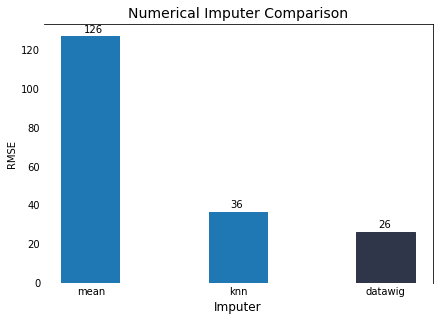

In [ ]:
#Graph
method = ['mean', 'knn', 'datawig']
value = [mean_rmse, knn_rmse, dw_rmse]
fig = plt.figure()
ax = fig.add_axes([0,0,0.9,0.9], alpha = 0)
ax.set_title('Numerical Imputer Comparison', fontsize = 14)
ax.set_xlabel('Imputer', fontsize =12)
ax.set_ylabel('RMSE', fontsize =10)
ax.bar(method,value, width = 0.4)
#Place text on top of bars
for i, v in enumerate(value):
    ax.text(i - 0.05, v + 2, str(int(v)))
#Locate the bar you want to change the color of
ax.get_children()[2].set_color('#2f3649')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.show()

# Numerical Data not missing at random

In [ ]:
months = ['May', 'Jun']
flights_test = flights[flights.month.isin(months)]
flights_train = flights[~(flights.month.isin(months))]

In [ ]:
imputer = datawig.SimpleImputer(
    input_columns=['year', 'month'],
    output_column='passengers'
    )

imputer.fit(train_df = flights_train)

imputed = imputer.predict(flights_test)

In [ ]:
dw_rmse_nr = (mse(imputed['passengers'], imputed['passengers_imputed']))**0.5

In [ ]:
dw_rmse_nr

19.23310845834729

In [ ]:
from feature_engine.imputation import EndTailImputer
et_imputer = EndTailImputer(imputation_method='gaussian', tail='right')

# fit the imputer to the train set
et_imputer.fit(pd.DataFrame(flights_train['passengers']))
y = np.empty(len(flights_test))
y[:] = np.nan
# transform the data
test_results = et_imputer.transform(pd.DataFrame(y, columns = ['passengers']))

In [ ]:
test_results

,passengers
0,636.763006
1,636.763006
2,636.763006
3,636.763006
4,636.763006
5,636.763006
6,636.763006
7,636.763006
8,636.763006
9,636.763006


In [ ]:
const_rmse_nr = (mse(flights_test['passengers'], test_results)) ** 0.5

In [ ]:
const_rmse_nr

365.67961201719976

In [ ]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
flights_train_ohe = pd.DataFrame(ohe.fit_transform(flights_train[['month']]).toarray())
flights_train = flights_train.reset_index(drop= True)
flights_train = flights_train.join(flights_train_ohe)
train_y = np.array(flights_train['passengers'])
flights_train = flights_train.drop(columns = ['month', 'passengers'])
flights_train['passengers'] = train_y

flights_test_ohe = pd.DataFrame(ohe.transform(flights_test[['month']]).toarray())
flights_test = flights_test.reset_index(drop= True)
flights_test = flights_test.join(flights_test_ohe)
test_y = np.array(flights_test['passengers'])
nans = np.empty(len(flights_test))
nans[:] = np.nan
flights_test = flights_test.drop(columns = ['month', 'passengers'])
flights_test['passengers'] = nans

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(flights_train)
knn_imputations = pd.DataFrame(knn_imputer.transform(flights_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
knn_rmse_nr = (mse(test_y, knn_imputations[11])) ** 0.5

In [ ]:
knn_rmse_nr

29.910087484548313

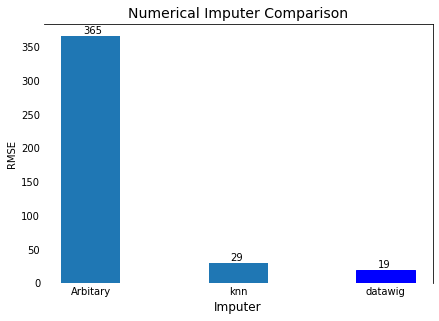

In [ ]:
method_nr = ['Arbitary', 'knn', 'datawig']
value_nr = [const_rmse_nr, knn_rmse_nr, dw_rmse_nr]

fig = plt.figure()
ax = fig.add_axes([0,0,0.9,0.9], alpha = 0)
#plt.rc('text', color = 'white' )
#plt.rc('axes', titlecolor = 'white', labelcolor = 'white' )

ax.set_title('Numerical Imputer Comparison', fontsize = 14)
ax.set_xlabel('Imputer', fontsize =12)
ax.set_ylabel('RMSE', fontsize =10)
ax.bar(method_nr,value_nr, width = 0.4)
#Place text on top of bars
for i, v in enumerate(value_nr):
    ax.text(i - 0.05, v + 4, str(int(v)))
#Locate the bar you want to change the color of
ax.get_children()[2].set_color('blue')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)
#fig.set_facecolor('black')
#ax.set_facecolor('black')
plt.show()

# Categorical Data Missing at Random

In [ ]:
shoes = pd.read_csv('https://raw.githubusercontent.com/anshbordia/DataWig-examples/main/shoes.csv')
shoes = shoes.sample(n = 5000)

In [ ]:
shoes = shoes.drop(columns = ['CID'])

In [ ]:
shoes_train, shoes_test = datawig.utils.random_split(shoes)

In [ ]:
shoes

,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle
33281,Boots,Ankle,1in - 1 3/4in,Padded,Zipper,Women,Leather,Capped Toe;Round Toe;Closed Toe
34442,Boots,Ankle,2in - 2 3/4in,Padded,Zipper,Women,Synthetic,Almond;Closed Toe
20222,Shoes,Sneakers and Athletic Shoes,NaN,Padded;Removable,Lace up,Men,Synthetic,NaN
33732,Sandals,Flat,3in - 3 3/4in,Padded,Slip-On;Sling Back,Women,Canvas;Cotton,Open Toe
5501,Shoes,Flats,1in - 1 3/4in,Latex Lined;Moisture Wicking;Padded,Elastic Gore,Women,Leather,Round Toe;Closed Toe
...,...,...,...,...,...,...,...,...
7538,Shoes,Heels,4in - 4 3/4in,NaN,Slip-On,Women,Leather,Round Toe
14009,Shoes,Sneakers and Athletic Shoes,NaN,Leather;Polyurethane;Removable,Lace up,Men,Leather;Nubuck;Polyester;Rubber,NaN
7027,Boots,Mid-Calf,1in - 1 3/4in,Leather;Padded,Pull-on,Women,Leather,Round Toe
1621,Sandals,Flat,1in - 1 3/4in,EVA,Hook and Loop,Women,Leather;Nubuck;Rubber,NaN


In [ ]:
#Fit DataWig imputer and predict
imputer = datawig.SimpleImputer(
    input_columns=['Category', 'SubCategory', 'HeelHeight', 'Insole', 'Closure', 'Material', 'ToeStyle'],
    output_column='Gender'
    )

imputer.fit(train_df = shoes_train)

imputed = imputer.predict(shoes_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
imputed

,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle,Gender_imputed,Gender_imputed_proba
10644,Shoes,Sneakers and Athletic Shoes,NaN,Padded;Removable,Lace up,Men,Mesh;Synthetic,NaN,Men,0.401780
48840,Sandals,Flat,3in - 3 3/4in,NaN,Zipper,Women,Leather;Nubuck,Open Toe,Women,0.999084
32597,Boots,Mid-Calf,1in - 1 3/4in,Leather;Padded,Pull-on,Men,Leather,Square Toe;Closed Toe,Women,0.548588
31540,Boots,Mid-Calf,1in - 1 3/4in,Leather,Zipper,Men,Lace;Leather,NaN,Girls,0.478972
16261,Sandals,Flat,1in - 1 3/4in,Moisture Wicking;Padded,Hook and Loop,Women,Leather,Open Toe,Women,0.794921
...,...,...,...,...,...,...,...,...,...,...
42778,Boots,Mid-Calf,1in - 1 3/4in,NaN,Bungee;Pull-on,Boys,Microfiber;Nylon;Ripstop,Round Toe;Closed Toe,Boys,0.318288
17491,Shoes,Flats,NaN,Memory Foam;Padded,Hook and Loop,Women,Mesh;Suede,Round Toe;Closed Toe,Girls,0.529973
38585,Boots,Mid-Calf,Flat,NaN,Zipper,Girls,Leather;Synthetic,Round Toe;Closed Toe,Girls,0.581378
419,Sandals,Flat,NaN,EVA,Slip-On,Women,NaN,Open Toe,Women,0.571813


In [ ]:
from sklearn.metrics import accuracy_score

dw_acc = accuracy_score(imputed['Gender'], imputed['Gender_imputed'])

In [ ]:
dw_acc

0.686

In [ ]:
from feature_engine.imputation import RandomSampleImputer
# create the imputer
random_imputer = RandomSampleImputer(random_state = 42)
random_imputer.fit(pd.DataFrame(shoes_train['Gender']))
y = np.empty(len(shoes_test))
y[:] = np.nan
test_results = random_imputer.transform(pd.DataFrame(y, columns = ['Gender']))

In [ ]:
rs_acc = accuracy_score(shoes_test['Gender'], test_results)

In [ ]:
rs_acc

0.346

In [ ]:
shoes_train.Gender.value_counts()

Women         2140
Men            993
Girls          412
Boys           258
Boys;Girls     110
Men;Women       87
Name: Gender, dtype: int64

In [ ]:
most_common = ['Women'] * len(shoes_test)
mode_acc = accuracy_score(shoes_test['Gender'], most_common)

In [ ]:
mode_acc

0.557

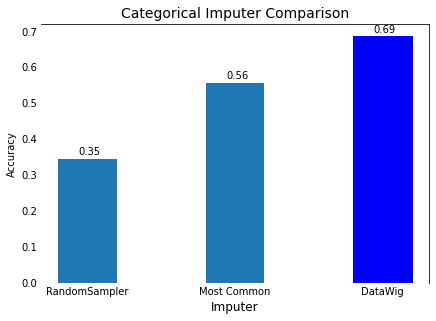

In [ ]:
method_cat = ['RandomSampler', 'Most Common', 'DataWig']
value_cat = [rs_acc, mode_acc, dw_acc]

fig = plt.figure()
ax = fig.add_axes([0,0,0.9,0.9], alpha = 0)
#plt.rc('text', color = 'white' )
#plt.rc('axes', titlecolor = 'white', labelcolor = 'white' )

ax.set_title('Categorical Imputer Comparison', fontsize = 14)
ax.set_xlabel('Imputer', fontsize =12)
ax.set_ylabel('Accuracy', fontsize =10)
ax.bar(method_cat,value_cat, width = 0.4)
#Place text on top of bars
for i, v in enumerate(value_cat):
    ax.text(i - 0.06, v + 0.01, str(round(v,2)))
#Locate the bar you want to change the color of
ax.get_children()[2].set_color('blue')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)
#fig.set_facecolor('black')
#ax.set_facecolor('black')
plt.show()

# Categorical Data not Missing at Random

In [ ]:
shoes_test = shoes[shoes.Category == 'Boots']
shoes_train = shoes[shoes.Category != 'Boots']

In [ ]:
(shoes[shoes.Gender == 'Women']).Category.value_counts()

Shoes       1431
Boots        759
Sandals      452
Slippers      55
Name: Category, dtype: int64

In [ ]:
shoes.Category.value_counts()

Shoes       3001
Boots       1295
Sandals      589
Slippers     115
Name: Category, dtype: int64

In [ ]:
shoes.Gender.value_counts()

Women         2697
Men           1209
Girls          524
Boys           340
Boys;Girls     128
Men;Women      102
Name: Gender, dtype: int64

In [ ]:
imputer = datawig.SimpleImputer(
    input_columns=['Category', 'SubCategory', 'HeelHeight', 'Insole', 'Closure', 'Material', 'ToeStyle'],
    output_column='Gender'
    )

imputer.fit(train_df = shoes_train)

imputed = imputer.predict(shoes_test)

In [ ]:
dw_acc_nr = accuracy_score(imputed['Gender'], imputed['Gender_imputed'])

In [ ]:
random_imputer = RandomSampleImputer(random_state = 42)
random_imputer.fit(pd.DataFrame(shoes_train['Gender']))
y = np.empty(len(shoes_test))
y[:] = np.nan
test_results = random_imputer.transform(pd.DataFrame(y, columns = ['Gender']))

In [ ]:
rs_acc_nr = accuracy_score(shoes_test['Gender'], test_results)
rs_acc_nr

0.36293436293436293

In [ ]:
most_common = ['Women'] * len(shoes_test)
mode_acc_nr = accuracy_score(shoes_test['Gender'], most_common)

In [ ]:
mode_acc_nr

0.5861003861003861

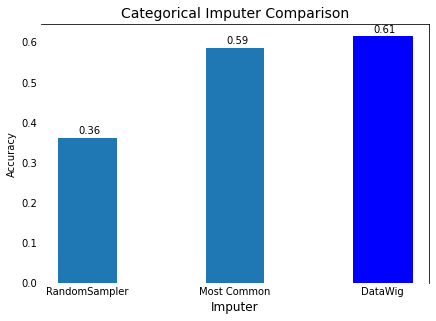

In [ ]:
method_cat = ['RandomSampler', 'Most Common', 'DataWig']
value_cat = [rs_acc_nr, mode_acc_nr, dw_acc_nr]

fig = plt.figure()
ax = fig.add_axes([0,0,0.9,0.9], alpha = 0)
#plt.rc('text', color = 'white' )
#plt.rc('axes', titlecolor = 'white', labelcolor = 'white' )

ax.set_title('Categorical Imputer Comparison', fontsize = 14)
ax.set_xlabel('Imputer', fontsize =12)
ax.set_ylabel('Accuracy', fontsize =10)
ax.bar(method_cat,value_cat, width = 0.4)
#Place text on top of bars
for i, v in enumerate(value_cat):
    ax.text(i - 0.06, v + 0.01, str(round(v,2)))
#Locate the bar you want to change the color of
ax.get_children()[2].set_color('blue')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)
#fig.set_facecolor('black')
#ax.set_facecolor('black')
plt.show()